# 0. Importation des Metadata pour avoir des informations sur les produits

### Présentation du dataset de Metadata

#### Schéma de données des metadata

| Nom de la colonne | Type | Nullable |
|-------------------|------|----------|
| also_buy          | array<string> | true |
| also_view         | array<string> | true |
| asin              | string | true |
| brand             | string | true |
| category          | array<string> | true |
| date              | string | true |
| description       | array<string> | true |
| details           | struct | true |
| Item Weight       | string | true |
| Product Dimensions| string | true |
| ASIN::            | string | true |
| ASIN:             | string | true |
| Apparel           | string | true |
| Audio CD          | string | true |
| Audio Cassette    | string | true |
| Blu-ray Audio     | string | true |
| DVD               | string | true |
| DVD Audio         | string | true |
| Label::           | string | true |
| MP3 Music         | string | true |
| Note on Boxed Sets:: | string | true |
| Number of Discs:: | string | true |
| Original Release Date:: | string | true |
| Please Note::     | string | true |
| Run Time::        | string | true |
| SPARS Code::      | string | true |
| Shipping Weight:: | string | true |
| UPC::             | string | true |
| Vinyl             | string | true |
| Vinyl Bound       | string | true |
| feature           | array<string> | true |
| fit               | string | true |
| imageURL          | array<string> | true |
| imageURLHighRes   | array<string> | true |
| main_cat          | string | true |
| price             | string | true |
| rank              | string | true |
| similar_item      | string | true |
| tech1             | string | true |
| tech2             | string | true |
| title             | string | true |

#### Nombre de lignes du DataFrame metadata_spark

Nombre de lignes du DataFrame metadata : 74 347
Le créateur du dataset indique qu'il existe 465 392 musiques différentes, nous les avons bien dans le dataset (*rating only*) mais en vérité, nous trouvons seulement 74 347 musiques différentes, ce qui fait que nous ne pouvons pas récupérer les informations de toutes les musiques.
Pour remédier à cela, nous utiliserons les liens internet Amazon des musiques pour la partie filtrage collaboratif.

### Intialisation

Utilisation de Spark pour gérer un grand nombre de données.
Nous pouvons gérer un grand nombre d'enregistrement (10 000 dans notre exemple) assez rapidement.

In [52]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, BooleanType, ArrayType, MapType
import gzip
import shutil
import time

# Chemin du fichier compressé
compressed_file_path = '../meta_Digital_Music.json.gz'
# Chemin du fichier décompressé
decompressed_file_path = '../meta_Digital_Music.jsonl'

# Décompression du fichier
with gzip.open(compressed_file_path, 'rb') as f_in:
    with open(decompressed_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

meta_datas = decompressed_file_path
# Vérification du nombre d'objets dans le fichier JSON

with open(decompressed_file_path, 'r') as file:
    num_lines = sum(1 for line in file)
print(f"Nombre d'objets dans le fichier JSON: {num_lines}")

# Créer une session Spark
spark = SparkSession.builder.appName("AmazonDigitalMusicMetadata").getOrCreate()

# Charger les données JSON en DataFrame Spark en utilisant les schémas définis
metadata_spark = spark.read.json(meta_datas)

# Afficher le schéma pour vérifier la structure des données
metadata_spark.printSchema()

# Afficher le nombre de lignes du DataFrame
print(f"Nombre de lignes du DataFrame metadata_spark: {metadata_spark.count()}")

# Afficher les 10000 premières lignes du DataFrame et évaluer le temps de réponse
start_time = time.time()
metadata_spark.show(10, truncate=False)
end_time = time.time()

print(f"Temps d'exécution de la requête des 10000 premières lignes: {end_time - start_time} secondes")

Nombre d'objets dans le fichier JSON: 74347
root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Apparel: string (nullable = true)
 |    |-- Audio CD: string (nullable = true)
 |    |-- Audio Cassette: string (nullable = true)
 |    |-- Blu-ray Audio: string (nullable = true)
 |    |-- DVD: string (nullable = true)
 |   

### Fonction de récupération des informations sur une musique en fonction de son ID (*asin*)

In [53]:
def get_music_info(asin):
    """
    Récupère les informations sur un produit en fonction de son ID (asin).
    
    Arguments:
        asin: identifiant du produit (asin)
    
    Retourne:
        DataFrame contenant les informations du produit
    """
    music_info = metadata_spark.filter(metadata_spark.asin == asin).orderBy(metadata_spark.columns, ascending=False).limit(1)
    return music_info

Exemple d'utilisation :

In [54]:
asin = "7799420340"

music_info = get_music_info(asin)

# Afficher les informations du produit
music_info.show(truncate=False)

# Afficher la colonne "title" du produit
music_info.select("title").show(truncate=False)

# Afficher la colonne "also_buy" du produit
music_info.select("also_buy").show(truncate=False)

# Afficher le premier élément de la colonne "also_buy" du produit
first_also_buy = music_info.select("also_buy").first()["also_buy"][0]
print(first_also_buy)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [55]:
import requests
from bs4 import BeautifulSoup
from IPython.display import Image, display
def get_image_url(asin):
    url = f"https://www.amazon.com/dp/{asin}/"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    image_element = soup.select_one("#landingImage")
    if image_element:
        image_url = image_element["src"]
        return image_url
    else:
        return None

# 1. Filtrage collaboratif

## 1. Exploration des données

#### Choix des données:
Nous avons choisi comme données les **"Amazon Review Data" de 2018**, plus précisément un **sous-ensemble** de la catégorie **"Digital Music"** ("Small subsets for experimentation").

#### Le fichier utilisé est disponible aux adresses suivantes:
- https://nijianmo.github.io/amazon/index.html **-> "Digital Music ratings only (1,584,082 ratings)"**
- https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music.csv *(lien direct)*

In [56]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Lecture des données et print des 5 premières lignes

In [57]:
digital_music = pd.read_csv("Digital_Music.csv")
digital_music.head()

,product_asin,user_id,rating,timestamp
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400
3,0001388703,A3A0W7FZXM0IZW,5.0,1354406400
4,0001388703,A12R54MKO17TW0,5.0,1325894400


### Quelsques informations sur nos données (nombre d'évaluations, nombre de musiques...)

In [58]:
n_evaluation = len(digital_music)
n_musique = digital_music['product_asin'].nunique()
n_utilisateur = digital_music['user_id'].nunique()

print("{:,}".format(n_evaluation) + " évaluations")
print("{:,}".format(n_musique) + " musiques")
print("{:,}".format(n_utilisateur) + " utilisateurs")
print("Nombre moyen d'évaluations par utilisateur : " + str(round(n_evaluation/n_utilisateur, 1)))
print("Nombre moyen d'évaluations par musique : " + str(round(n_evaluation/n_musique, 1)))

1,584,082 évaluations
456,992 musiques
840,372 utilisateurs
Nombre moyen d'évaluations par utilisateur : 1.9
Nombre moyen d'évaluations par musique : 3.5


### Pour un utilisateur donné, combien d'évaluations a-t-il effectuées ?

In [59]:
nb_evaluations_par_utilisateur = digital_music[['user_id', 'product_asin']].groupby('user_id').count().reset_index()
nb_evaluations_par_utilisateur.columns = ['user_id', 'n_evaluation']
nb_evaluations_par_utilisateur.head()

,user_id,n_evaluation
0,A00041408PB8URN3FSQ6,1
1,A0009988MRFQ3TROTQPI,2
2,A0015420M7GRKSKTW32Z,1
3,A0025284EDB2S5Q3G9PD,1
4,A002800078UB6PFVGW0Q,1


### Nombre maximum d'évaluations faites par un utilisateur

In [60]:
max(nb_evaluations_par_utilisateur["n_evaluation"])

1326

### Nombre minimum d'évaluations faites par un utilisateur

In [61]:
min(nb_evaluations_par_utilisateur["n_evaluation"])

1

### Visualisation de la distribution des notes et du nombre d'évaluations par utilisateur

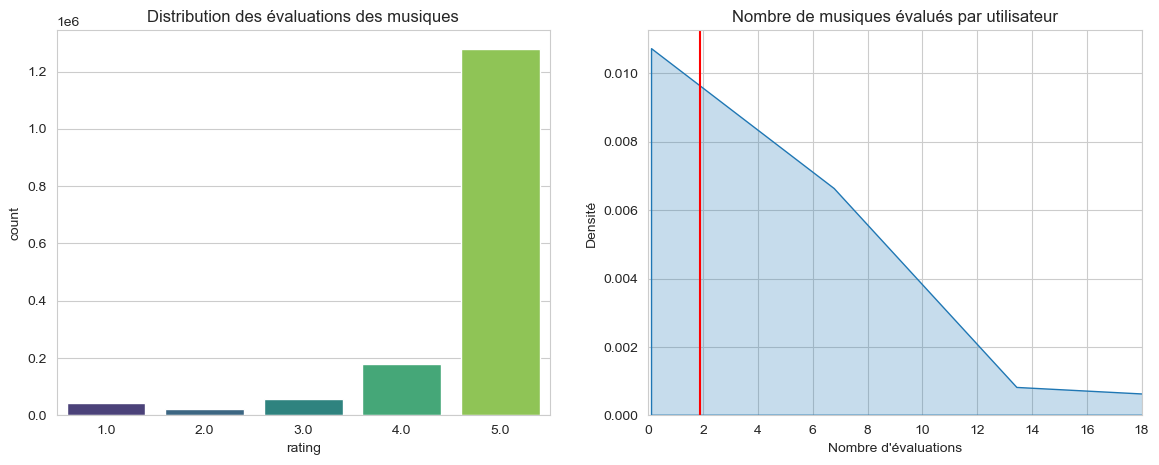

In [62]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))

# Sous-graphique Distribution des évaluations des musiques
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=digital_music, palette="viridis")
plt.title("Distribution des évaluations des musiques")

# Sous-graphique Nombre de musiques évalués par utilisateur
plt.subplot(1,2,2)
ax = sns.kdeplot(nb_evaluations_par_utilisateur['n_evaluation'], shade=True, legend=False)
plt.axvline(nb_evaluations_par_utilisateur['n_evaluation'].mean(), color="r", linestyle="-")
plt.xlabel("Nombre d'évaluations")
plt.ylabel("Densité")
plt.title("Nombre de musiques évalués par utilisateur")
plt.xlim(0, 18)

plt.show()

### Note moyenne de chaque musique

In [63]:
moyenne_par_digital_music = digital_music.groupby('product_asin')[['rating']].mean()
moyenne_par_digital_music.head()

,rating
product_asin,
0001377647,5.000000
0001388703,4.571429
0001526146,4.891304
0001527134,4.878788
0001529145,5.000000


### La musique la mieux notée

In [64]:
highest_rated = moyenne_par_digital_music['rating'].idxmax()
print("https://www.amazon.com/dp/" + highest_rated + "/")
print("Moyenne de " + str(moyenne_par_digital_music.loc[highest_rated, 'rating']) + " selon " + str(digital_music[digital_music['product_asin']==highest_rated].shape[0]) + " votes")

https://www.amazon.com/dp/0001377647/
Moyenne de 5.0 selon 39 votes


### La musique la moins bien notée

In [65]:
lowest_rated = moyenne_par_digital_music['rating'].idxmin()
print("https://www.amazon.com/dp/" + lowest_rated + "/")
print("Moyenne de " + str(moyenne_par_digital_music.loc[lowest_rated, 'rating']) + " selon " + str(digital_music[digital_music['product_asin']==lowest_rated].shape[0]) + " votes")

https://www.amazon.com/dp/0970154275/
Moyenne de 1.0 selon 1 votes


### La musique avec la note moyenne la plus faible n'a reçu qu'un seul vote. 
### Ce n'est pas une bonne mesure de la popularité d'une musique. 
### La qualité de l'évaluation d'une musique dépend non seulement de la note moyenne, mais aussi du nombre d'évaluations.
### Il faudrait calculer la moyenne bayésienne mais en raison des limitations de performance nous n'allons pas le faire.

## 2. Transformation des données
### Besoin de transformer les données en matrice utilisateur-item pour le filtrage collaboratif 
### Les colonnes sont des musiques et les lignes des utilisateurs
### Chaque cellule est remplie avec l'évaluation d'un utilisateur par rapport à un film
### Cellule vide = pas d'évaluation disponible

In [66]:
from scipy.sparse import csr_matrix

def creer_X(df):
    """
    Génère une matrice creuse à partir du DataFrame des évaluations.
    
    Arguments:
        df: DataFrame pandas
    
    Retourne:
        X: matrice creuse
        utilisateur_mapper: dictionnaire qui associe les identifiants d'utilisateurs aux indices des utilisateurs
        utilisateur_inv_mapper: dictionnaire qui associe les indices des utilisateurs aux identifiants des utilisateurs
        musique_mapper: dictionnaire qui associe les identifiants de films aux indices des films
        musique_inv_mapper: dictionnaire qui associe les indices des films aux identifiants des films
    """
    N = df['user_id'].nunique()  # Nombre d'utilisateurs uniques
    M = df['product_asin'].nunique()  # Nombre de musiques uniques

    utilisateur_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))  # Mapper des utilisateurs
    musique_mapper = dict(zip(np.unique(df["product_asin"]), list(range(M))))  # Mapper des musiques
    
    utilisateur_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))  # Mapper inversé pour les utilisateurs
    musique_inv_mapper = dict(zip(list(range(M)), np.unique(df["product_asin"])))  # Mapper inversé pour les musiques
    
    index_utilisateur = [utilisateur_mapper[i] for i in df['user_id']]  # Index des utilisateurs
    index_musique = [musique_mapper[i] for i in df['product_asin']]  # Index des musiques

    X = csr_matrix((df["rating"], (index_musique, index_utilisateur)), shape=(M, N))  # Création de la matrice creuse
    
    return X, utilisateur_mapper, musique_mapper, utilisateur_inv_mapper, musique_inv_mapper

In [67]:
X, user_mapper, musique_mapper, user_inv_mapper, musique_inv_mapper = creer_X(digital_music)

### Calculons la Sparsity de la matrice

In [68]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])*100

print(f"Matrix sparsity: {sparsity} %")

Matrix sparsity: 0.0003948906477302037 %


### La matrice est trop vide pour faire de bonnes recommandations...
### Nous allons créer un nouveau dataframe contenant uniquement les musiques ayant plus de 35 évaluations, puis le filtrer à nouveau en ne conservant que les évaluations des utilisateurs ayant plus de 35 évaluations

In [69]:
musique_counts = digital_music['product_asin'].value_counts()
popular_musique = musique_counts[musique_counts > 35].index

digital_music_filtered = digital_music[digital_music['product_asin'].isin(popular_musique)]

user_ratings_count = digital_music_filtered['user_id'].value_counts()
filtered_users = user_ratings_count[user_ratings_count > 35].index
digital_music_filtered = digital_music_filtered[digital_music_filtered['user_id'].isin(filtered_users)]
digital_music_filtered.head()

,product_asin,user_id,rating,timestamp
1465,7799420340,A9Q28YTLYREO7,5.0,1121731200
1466,7799420340,A3W4D8XOGLWUN5,4.0,1121731200
1526,7799420340,A1VTEL32W5FM13,5.0,1483228800
1868,7799420340,A3W4D8XOGLWUN5,4.0,1261699200
1939,7799420340,A2R6RA8FRBS608,5.0,1249689600


### Quelsques informations sur nos données filtered (nombre d'évaluations, nombre de musiques...)

In [70]:
n_evaluation = len(digital_music_filtered)
n_musique = digital_music_filtered['product_asin'].nunique()
n_utilisateur = digital_music_filtered['user_id'].nunique()

print("{:,}".format(n_evaluation) + " évaluations")
print("{:,}".format(n_musique) + " musiques")
print("{:,}".format(n_utilisateur) + " utilisateurs")
print("Nombre moyen d'évaluations par utilisateur : " + str(round(n_evaluation/n_utilisateur, 1)))
print("Nombre moyen d'évaluations par musique : " + str(round(n_evaluation/n_musique, 1)))

9,364 évaluations
2,974 musiques
166 utilisateurs
Nombre moyen d'évaluations par utilisateur : 56.4
Nombre moyen d'évaluations par musique : 3.1


In [71]:
X, user_mapper, musique_mapper, user_inv_mapper, musique_inv_mapper = creer_X(digital_music_filtered)

### Calculons la Sparsity de la matrice des données filtered

In [72]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.51%


### Sauvegarde de notre matrice

In [73]:
from scipy.sparse import save_npz

save_npz('user_item_matrix.npz', X)

In [74]:
from sklearn.neighbors import NearestNeighbors

def find_similar_musique(musique_asin, X, k):
    """
    Trouve les k-voisins les plus proches pour un identifiant de musique donné.
    Args :
        musique_asin : identifiant de la musique
        X : matrice utilisateur-item
        k : nombre de musiques similaires à récupérer
    
    Returns :
        liste des k musiques similaires sous forme d'ASIN
    """
    neighbour_ids = []
    
    musique_ind = musique_mapper[musique_asin]
    musique_vec = X[musique_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
    kNN.fit(X)
    if isinstance(musique_vec, (np.ndarray)):
        musique_vec = musique_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(musique_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(musique_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

def find_similar_musique_et_rep(musique_asin, X, k):
    similar_music_asin = find_similar_musique(musique_asin, X, k)
    
    print("Parce que vous avez écouté " + string_asin_info(musique_asin) + " : " + "https://www.amazon.com/dp/" + musique_asin + "/")
    image_url = get_image_url(musique_asin)
    if image_url:
        display(Image(url=image_url))
    print("-----------------------------------------------------------------")
    for i in similar_music_asin:
        print(" • Nous vous recommandons " + string_asin_info(i) + " : " + "https://www.amazon.com/dp/" + i + "/")
        image_url = get_image_url(i)
        if image_url:
            display(Image(url=image_url))

def string_asin_info(asin):
    music_info = get_music_info(asin)

    titre_row = music_info.select("title").first()
    titre = titre_row["title"] if titre_row and titre_row["title"] else "Titre inconnu"

    if "brand" in music_info.columns:
        groupe_row = music_info.select("brand").first()
        groupe = groupe_row["brand"] if groupe_row and groupe_row["brand"] else "Groupe inconnu"
    else:
        groupe = "Groupe inconnu"

    return titre + " par " + groupe

## 3. Test (filtrage collaboratif)

### Exemple : Pour 'Essential' de Michael Jackson (7799420340)
> Parmi les 3 recommandations, **on retrouve 'Pure McCartney' de Paul McCartney (B01DKYRCEY)** -> Notons que **'Essential' de Michael Jackson contient un duo avec Paul McCartney**.

In [75]:
find_similar_musique_et_rep("7799420340", X, k=3)

Parce que vous avez écouté Essential par Michael Jackson : https://www.amazon.com/dp/7799420340/


-----------------------------------------------------------------
 • Nous vous recommandons Titre inconnu par Groupe inconnu : https://www.amazon.com/dp/B01DKYRCEY/
 • Nous vous recommandons Whispering Grass [Audio CD] par Ink Spots : https://www.amazon.com/dp/B000025Y5D/
 • Nous vous recommandons Titre inconnu par Groupe inconnu : https://www.amazon.com/dp/B01F54322S/


### Exemples

In [76]:
find_similar_musique_et_rep("B001BIQPB8", X, k=3)

Parce que vous avez écouté Titre inconnu par Groupe inconnu : https://www.amazon.com/dp/B001BIQPB8/
-----------------------------------------------------------------
 • Nous vous recommandons Titre inconnu par Groupe inconnu : https://www.amazon.com/dp/B01FTCOKF4/
 • Nous vous recommandons Titre inconnu par Groupe inconnu : https://www.amazon.com/dp/B006P06BPM/
 • Nous vous recommandons Titre inconnu par Groupe inconnu : https://www.amazon.com/dp/B00EONYSZW/


In [77]:
stop = 0
for i in digital_music_filtered['product_asin'].unique():
    stop += 1 
    if stop < 30:
        print(i + " (" + string_asin_info(i) + ") : https://www.amazon.com/dp/" + i + "/")

7799420340 (Essential par Michael Jackson) : https://www.amazon.com/dp/7799420340/
9714721180 (<span class="a-size-medium a-color-secondary a-text-normal" par Metallica) : https://www.amazon.com/dp/9714721180/
B00000I7LP (Slim Shady par Eminem) : https://www.amazon.com/dp/B00000I7LP/
B000025Y5D (Whispering Grass [Audio CD] par Ink Spots) : https://www.amazon.com/dp/B000025Y5D/
B00004WPC6 (Surf's Up par The Beach Boys) : https://www.amazon.com/dp/B00004WPC6/
B000OZAGG4 (Carroll Roberson sings Gospel Favorites par Carroll Roberson) : https://www.amazon.com/dp/B000OZAGG4/
B000QO3H3W (Titre inconnu par Groupe inconnu) : https://www.amazon.com/dp/B000QO3H3W/
B000QO760C (Titre inconnu par Groupe inconnu) : https://www.amazon.com/dp/B000QO760C/
B000QOEN6W (Titre inconnu par Groupe inconnu) : https://www.amazon.com/dp/B000QOEN6W/
B000QONMQ4 (Titre inconnu par Groupe inconnu) : https://www.amazon.com/dp/B000QONMQ4/
B000QP4IBG (Titre inconnu par Groupe inconnu) : https://www.amazon.com/dp/B000QP

# 2. Filtrage Content Based

In [78]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, col, array_join
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd
import requests
from bs4 import BeautifulSoup
from IPython.display import Image, display

# Créer une session Spark
spark = SparkSession.builder.appName("AmazonDigitalMusicMetadata").getOrCreate()

# Charger les données JSONL en DataFrame Spark sans spécifier de schéma
metadata_spark = spark.read.json("../meta_Digital_Music.jsonl")

# Combiner les colonnes pertinentes en une seule colonne de texte
metadata_spark = metadata_spark.withColumn("content", concat_ws(" ", col("title"), col("brand"), array_join(col("category"), " "), array_join(col("description"), " "), array_join(col("feature"), " ")))

# Convertir le DataFrame Spark en DataFrame Pandas
metadata_pd = metadata_spark.select("asin", "content").toPandas()

# Remplacer les valeurs nulles par des chaînes vides
metadata_pd["content"] = metadata_pd["content"].fillna("")

# Utiliser TfidfVectorizer pour transformer le texte en vecteurs de caractéristiques
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata_pd["content"])

# Créer une série pour mapper les indices aux titres des musiques
indices = pd.Series(metadata_pd.index, index=metadata_pd["asin"]).drop_duplicates()

# Fonction pour recommander des musiques similaires
def get_music_recommendations(asin, tfidf_matrix=tfidf_matrix, cosine_sim=linear_kernel):
    idx = indices[asin]
    tfidf_vector = tfidf_matrix[idx]
    cosine_similarities = cosine_sim(tfidf_vector, tfidf_matrix).flatten()
    sim_scores = list(enumerate(cosine_similarities))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Obtenir les 10 musiques les plus similaires
    music_indices = [i[0] for i in sim_scores]
    return metadata_pd["asin"].iloc[music_indices]


In [79]:
def print_content_based(asin):
    recommendations = get_music_recommendations(asin)
    # Afficher les recommandations en utilisant get_music_info
    print("Parce que vous avez écouté " + string_asin_info(asin) + " : " + "https://www.amazon.com/dp/" + asin + "/")
    image_url = get_image_url(asin)
    if image_url:
        display(Image(url=image_url))
    print("-----------------------------------------------------------------")
    for asin in recommendations:
        music_info = get_music_info(asin)
        titre_row = music_info.select("title").first()
        titre = titre_row["title"] if titre_row and titre_row["title"] else "Titre inconnu"

        if "brand" in music_info.columns:
            groupe_row = music_info.select("brand").first()
            groupe = groupe_row["brand"] if groupe_row and groupe_row["brand"] else "Groupe inconnu"
        else:
            groupe = "Groupe inconnu"

        string_asin_info_var = titre + " par " + groupe
        print(" • Nous vous recommandons " + string_asin_info_var + " : " + "https://www.amazon.com/dp/" + asin + "/")
        image_url = get_image_url(asin)
        if image_url:
            display(Image(url=image_url))
        else:
            image_url_high_res = music_info.select("imageURLHighRes").first()
            if image_url_high_res and image_url_high_res["imageURLHighRes"]:
                display(Image(url=image_url_high_res["imageURLHighRes"][0]))
            else:
                print("Image non disponible")



In [80]:
print_content_based("7799420340")

Parce que vous avez écouté Essential par Michael Jackson : https://www.amazon.com/dp/7799420340/
-----------------------------------------------------------------
 • Nous vous recommandons Michael Jackson: King of Pop - The China Collection (2 CDs) par Michael Jackson : https://www.amazon.com/dp/7799433337/
Image non disponible
 • Nous vous recommandons <span class="a-size-medium a-color-secondary a-text-normal" par Michael Jackson : https://www.amazon.com/dp/B000WJ8FK6/
Image non disponible
 • Nous vous recommandons Live in Japan 1987 (CD Album Michael Jackson, 13 Tracks) par Michael Jackson : https://www.amazon.com/dp/B002F4U4X2/


 • Nous vous recommandons I Just Can't Stop Loving You par Groupe inconnu : https://www.amazon.com/dp/B000X1R5F4/
Image non disponible
 • Nous vous recommandons Leave Me Alone par Michael Jackson : https://www.amazon.com/dp/B0043FJO7S/


 • Nous vous recommandons <span class="a-size-medium a-color-secondary a-text-normal" par Marvin Gaye : https://www.amazon.com/dp/B000MKLB2E/
Image non disponible
 • Nous vous recommandons Shake That Thing: Dip N Swing Music par Dirty Bunny : https://www.amazon.com/dp/B0030HT54M/
Image non disponible
 • Nous vous recommandons You Make Me Feel So Young par Groupe inconnu : https://www.amazon.com/dp/B000IZJ2X8/


 • Nous vous recommandons I Can't Stop Loving You; Born To Lose par Groupe inconnu : https://www.amazon.com/dp/B003NXKR36/
Image non disponible
 • Nous vous recommandons STOP THE WORLD, I WANT TO GET OFF - ORIGINAL UK CAST LP par Groupe inconnu : https://www.amazon.com/dp/B00175RUA0/
Image non disponible
